# SparkSession
* 스파크 애플리케이션은 SparkSession이라 불리는 드라이버 프로세스로 제어합니다. 
* SparkSession 인스턴스는 사용자가 정의한 처리 명령을 클러스터에서 실행
* 하나의 SparkSession은 하나의 스파크 애플리케이션에 대응합니다. 

In [1]:
spark

In [2]:
myRange = spark.range(1000).toDF("number")

In [6]:
myRange.explain()

== Physical Plan ==
*(1) Project [id#0L AS number#2L]
+- *(1) Range (0, 1000, step=1, splits=3)




In [4]:
myRange.show(5)

+------+
|number|
+------+
|     0|
|     1|
|     2|
|     3|
|     4|
+------+
only showing top 5 rows



* 위의 코드에서 생성한 DataFrame은 한 개의 컬럼과 1000개의 row로 구성되며 각 로우에는 0 ~ 999까지의 값이 할당 
* 이 숫자들은 분산 컬렉션을 나타냅니다. 
* 클러스터 모드에서 코드 예제를 실행하면 숫자 범위의 각 부분이 서로 다른 익스큐터에 할당됩니다. 
* 이것이 스파크의 DataFrame입니다. 

# DataFrame
* DataFrame은 가장 대표적인 구조적 API입니다. 
* 데이터를 로우와 컬럼으로 단순하게 표현 
* 컬럼과 컬럼의 타입을 정의한 목록을 스키마(schema)라고 부릅니다. 
* 스파크 DataFrame은 수천 대의 컴퓨터에 분산되어 있습니다. 

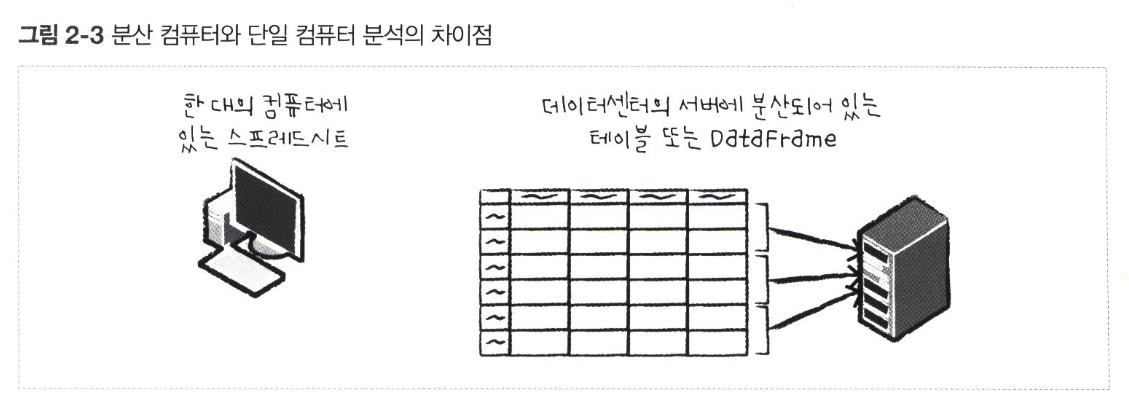

## 파티션
* 스파크는 모든 익스큐터가 병렬로 작업을 수행할 수 있도록 파티션이라는 불리는 청크 단위로 데이터를 분할 
* 파티션은 클러스터의 물리적 머신에 존재하는 로우의 집합을 의미 
* DataFrame의 파티션은 실행 중에 데이터가 컴퓨터 클러스터에서 물리적으로 분산되는 방식을 나타냅니다. 
* 만약 파티션이 하나라면 스파크에 수천 개의 익스큐터가 있더라도 병렬성은 1
* 수백 개의 파티션이 있더라도 익스큐터가 하나밖에 없다면 병렬성은 1

# 트랜스포메이션
* 스파크의 핵심 데이터 구조는 불변성(immutable)을 가집니다. 
* 즉 한번 생성하면 변경할 수 없음
* DataFrame을 변경하려면 원하는 변경 방법을 스파크에 알려줘야 함 
* 이때 사용하는 명령을 트랜스포메이션이라고 부름
* 아래 예제는 짝수를 찾는 간단한 트랜스포메이션 예제

In [7]:
divisBy2 = myRange.where("number % 2 = 0")

In [8]:
divisBy2.explain()

== Physical Plan ==
*(1) Project [id#0L AS number#2L]
+- *(1) Filter ((id#0L % 2) = 0)
   +- *(1) Range (0, 1000, step=1, splits=3)




In [10]:
divisBy2.show(3)

+------+
|number|
+------+
|     0|
|     2|
|     4|
+------+
only showing top 3 rows



* 위의 코드를 실행해도 결과는 출력되지 않습니다. 
* 추상적은 트랜스포메이션만 지정한 상태이기 때문에 액션을 호출하지 않으면 실제 트랜스포메이션을 수행하지 않음 
* 트랜스포메이션은 스파크에서 비즈니스 로직을 표현하는 핵심 개념

### 좁은 의존성
* 트랜스포메이션은 각 입력 파티션이 하나의 출력 파티션에만 영향을 미침
* 위의 예제는 좁은 의존성을 가짐

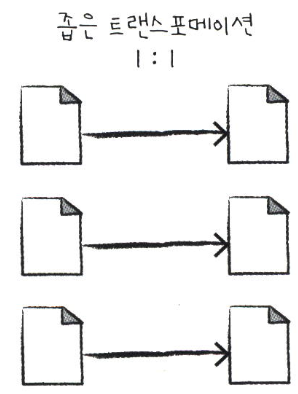

### 넓은 의존성
* 하나의 입력 파티션이 여러 출력 파티션에 영향을 미침
* 스파크가 클러스터에서 파티션을 교환하는 작업을 셔플이라고 함
* 좁은 트랜스포메이션을 사용하면 스파크에서 파이프라이닝을 자동을 수행. 즉 DataFrame에 여러 필터를 지정하는 경우 모든 작업이 메모리에서 일어남
* 하지만 셔플은 다른 방식으로 동작함. 셔플의 결과를 디스크에 저장함

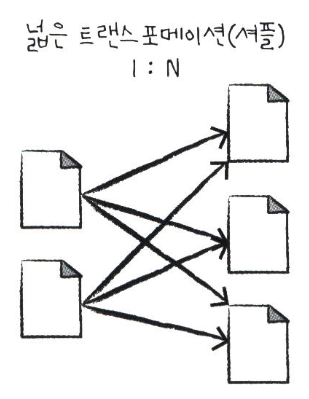

## 지연 연산
* 지연연산(lazy evaluation)은 스파크가 연산 그래프를 처리하기 직전까지 기다리는 동작 방식을 의미 
* 스파크는 특정 연산 명령어 내려진 즉시 데이터를 수정하지 않고 원시 데이터에 적용할 트랜스포메이션의 실행 계획을 생성 
* 스파크는 코드를 실행하는 마지막 순간까지 대기하다가 원형 DataFrame 트랜스포메이션을 간결한 물리적 실행 계획으로 컴파일
* 이 과정을 거치며 전체 데이터 흐름을 최적화하는 엄청난 강점을 가지고 있음 

# 액션
* 사용자는 트랜스포메이션을 사용해 논리적 실행 계획을 세울 수 있습니다. 
* 하지만 실제 연산을 수행하려면 액션 명령을 내려야 함 
* 액션은 일련의 트랜스포메이션으로부터 결과를 계산하도록 지시하는 명령

In [12]:
divisBy2.count()

500

* 액션을 지정하면 스파크 잡이 시작 
* 스파크 잡은 필터(좁은 트랜스포메이션)를 수행한 후 파티션별로 레코드 수를 카운트(넓은 트랜스포메이션) 합니다. 
* 그리고 각 언어에 적합한 네이티브 객체에 결과를 모읍니다. 

# 예제

* 미국 교통통계국의 항공운항 데이터를 사용해서 분석

* 스파크 DataFrame의 스키마 정보를 알아내는 schema inference 기능을 사용 

In [13]:
# hdfs 의 data/flight-data/csv/ 
flightData2015 = spark.read.option("inferSchema", "true").option("header", "true").csv("/data/flight-data/csv/2015-summary.csv")

In [ ]:
# hdfs 의 data/flight-data/csv/ 
flightData2015 = spark\
  .read\
  .option("inferSchema", "true")\
  .option("header", "true")\
  .csv("/data/flight-data/csv/2015-summary.csv")

* 스칼라와 파이썬에서 사용하는 DataFrame은 불특정 다수의 로우와 컬럼을 가짐 
* 로우의 수를 알 수 없는 이유는 데이터를 읽는 과정이 지연 연산 형태의 트랜스포메이션이기 때문임 

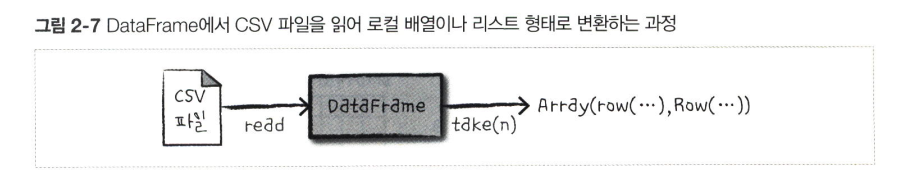

In [14]:
flightData2015.take(3)

[Row(DEST_COUNTRY_NAME='United States', ORIGIN_COUNTRY_NAME='Romania', count=15),
 Row(DEST_COUNTRY_NAME='United States', ORIGIN_COUNTRY_NAME='Croatia', count=1),
 Row(DEST_COUNTRY_NAME='United States', ORIGIN_COUNTRY_NAME='Ireland', count=344)]

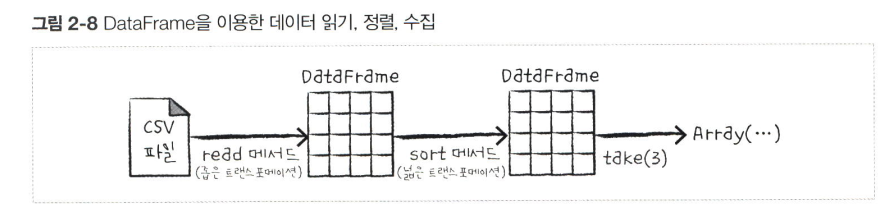

* 아래 sort 메서드는 단지 트랜스포메이션이기 때문에 호출 시 데이터에 아무런 변화도 일어나지 않습니다. 
* 하지만 스파크는 실행 계획을 만들고 검토하여 클러스터에서 처리할 방법을 알아냅니다. 

In [15]:
flightData2015.sort('count').explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- Sort [count#49 ASC NULLS FIRST], true, 0
   +- Exchange rangepartitioning(count#49 ASC NULLS FIRST, 200), ENSURE_REQUIREMENTS, [id=#173]
      +- FileScan csv [DEST_COUNTRY_NAME#47,ORIGIN_COUNTRY_NAME#48,count#49] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[hdfs://namenode:8020/data/flight-data/csv/2015-summary.csv], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<DEST_COUNTRY_NAME:string,ORIGIN_COUNTRY_NAME:string,count:int>




* 스파크는 셔플 수행 시 기본적으로 200개의 셔플 파티션을 생성
* 이 값을 5로 설정해 셔플의 출력 파티션 수를 줄입니다. 

In [16]:
spark.conf.set("spark.sql.shuffle.partitions", "5")

In [17]:
flightData2015.sort('count').explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- Sort [count#49 ASC NULLS FIRST], true, 0
   +- Exchange rangepartitioning(count#49 ASC NULLS FIRST, 5), ENSURE_REQUIREMENTS, [id=#183]
      +- FileScan csv [DEST_COUNTRY_NAME#47,ORIGIN_COUNTRY_NAME#48,count#49] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[hdfs://namenode:8020/data/flight-data/csv/2015-summary.csv], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<DEST_COUNTRY_NAME:string,ORIGIN_COUNTRY_NAME:string,count:int>




In [18]:
flightData2015.sort('count').take(3)

[Row(DEST_COUNTRY_NAME='Moldova', ORIGIN_COUNTRY_NAME='United States', count=1),
 Row(DEST_COUNTRY_NAME='United States', ORIGIN_COUNTRY_NAME='Croatia', count=1),
 Row(DEST_COUNTRY_NAME='United States', ORIGIN_COUNTRY_NAME='Singapore', count=1)]

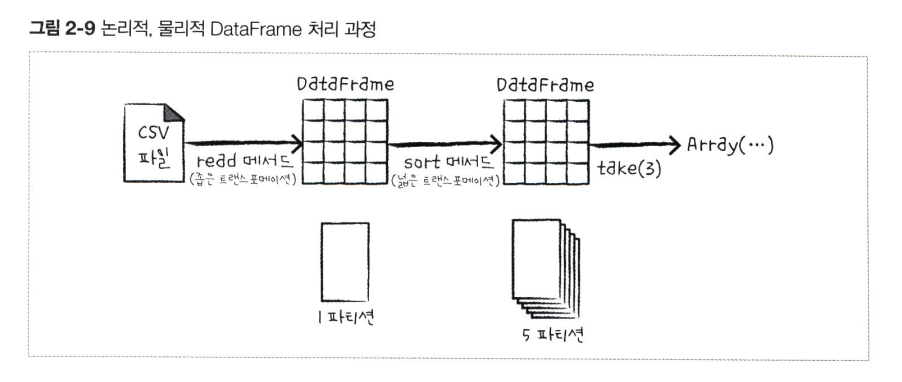

* 스파크는 실행계획을 통해 입력 데이터에 수행한 연산을 전체 파티션에서 어떻게 재연산하는지 알 수 있음
* 이 기능은 스파크의 프로그래밍 모델인 함수형 프로그래밍의 핵심
* 함수형 프로그래밍은 데이터의 변환 규칙이 일정한 경우 같은 입력에 대해 항상 같은 출력을 생성

## DataFrame과 SQL
* 스파크 SQL을 사용하면 모든 DataFrame을 테이블이나 뷰(임시 테이블)로 등록한 후 SQL 쿼리를 사용할 수 있음
* createOrReplaceTempView 메서드를 호출하면 모든 DataFrame을 테이블이나 뷰로 만들 수 있음

In [19]:
flightData2015.createOrReplaceTempView("flight_data_2015")

In [20]:
sqlWay = spark.sql("""
SELECT DEST_COUNTRY_NAME, count(1)
FROM flight_data_2015
GROUP BY DEST_COUNTRY_NAME
""")

In [24]:
sqlWay.show(10)

+--------------------+--------+
|   DEST_COUNTRY_NAME|count(1)|
+--------------------+--------+
|             Moldova|       1|
|             Bolivia|       1|
|             Algeria|       1|
|Turks and Caicos ...|       1|
|            Pakistan|       1|
|    Marshall Islands|       1|
|            Suriname|       1|
|              Panama|       1|
|         New Zealand|       1|
|             Liberia|       1|
+--------------------+--------+
only showing top 10 rows



In [25]:
dataFrameWay = flightData2015\
  .groupBy("DEST_COUNTRY_NAME")\
  .count()

In [26]:
dataFrameWay.show(5)

+--------------------+-----+
|   DEST_COUNTRY_NAME|count|
+--------------------+-----+
|             Moldova|    1|
|             Bolivia|    1|
|             Algeria|    1|
|Turks and Caicos ...|    1|
|            Pakistan|    1|
+--------------------+-----+
only showing top 5 rows



In [22]:
sqlWay.explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- HashAggregate(keys=[DEST_COUNTRY_NAME#47], functions=[count(1)])
   +- Exchange hashpartitioning(DEST_COUNTRY_NAME#47, 5), ENSURE_REQUIREMENTS, [id=#205]
      +- HashAggregate(keys=[DEST_COUNTRY_NAME#47], functions=[partial_count(1)])
         +- FileScan csv [DEST_COUNTRY_NAME#47] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[hdfs://namenode:8020/data/flight-data/csv/2015-summary.csv], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<DEST_COUNTRY_NAME:string>




In [23]:
dataFrameWay.explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- HashAggregate(keys=[DEST_COUNTRY_NAME#47], functions=[count(1)])
   +- Exchange hashpartitioning(DEST_COUNTRY_NAME#47, 5), ENSURE_REQUIREMENTS, [id=#218]
      +- HashAggregate(keys=[DEST_COUNTRY_NAME#47], functions=[partial_count(1)])
         +- FileScan csv [DEST_COUNTRY_NAME#47] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[hdfs://namenode:8020/data/flight-data/csv/2015-summary.csv], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<DEST_COUNTRY_NAME:string>




* max 함수 사용하기

In [27]:
from pyspark.sql.functions import max

In [28]:
flightData2015.select(max("count")).take(1)

[Row(max(count)=370002)]

In [29]:
maxSql = spark.sql("""
SELECT DEST_COUNTRY_NAME, sum(count) as destination_total
FROM flight_data_2015
GROUP BY DEST_COUNTRY_NAME
ORDER BY sum(count) DESC
LIMIT 5
""")


In [30]:
maxSql.show()

+-----------------+-----------------+
|DEST_COUNTRY_NAME|destination_total|
+-----------------+-----------------+
|    United States|           411352|
|           Canada|             8399|
|           Mexico|             7140|
|   United Kingdom|             2025|
|            Japan|             1548|
+-----------------+-----------------+



In [31]:
from pyspark.sql.functions import desc

flightData2015\
  .groupBy("DEST_COUNTRY_NAME")\
  .sum("count")\
  .withColumnRenamed("sum(count)", "destination_total")\
  .sort(desc("destination_total"))\
  .limit(5)\
  .show()

+-----------------+-----------------+
|DEST_COUNTRY_NAME|destination_total|
+-----------------+-----------------+
|    United States|           411352|
|           Canada|             8399|
|           Mexico|             7140|
|   United Kingdom|             2025|
|            Japan|             1548|
+-----------------+-----------------+



* 실행 계획은 트랜스포메이션의 지향성 비순환 그래프(directed acyclic graph, DAG)이며 액션이 호출되면 결과를 생성

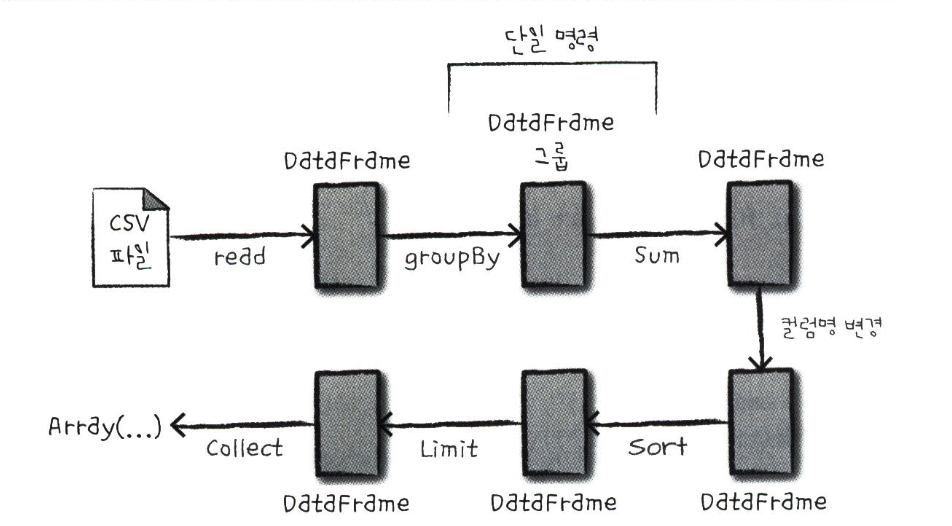

In [32]:
flightData2015\
  .groupBy("DEST_COUNTRY_NAME")\
  .sum("count")\
  .withColumnRenamed("sum(count)", "destination_total")\
  .sort(desc("destination_total"))\
  .limit(5)\
  .explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- TakeOrderedAndProject(limit=5, orderBy=[destination_total#163L DESC NULLS LAST], output=[DEST_COUNTRY_NAME#47,destination_total#163L])
   +- HashAggregate(keys=[DEST_COUNTRY_NAME#47], functions=[sum(count#49)])
      +- Exchange hashpartitioning(DEST_COUNTRY_NAME#47, 5), ENSURE_REQUIREMENTS, [id=#476]
         +- HashAggregate(keys=[DEST_COUNTRY_NAME#47], functions=[partial_sum(count#49)])
            +- FileScan csv [DEST_COUNTRY_NAME#47,count#49] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[hdfs://namenode:8020/data/flight-data/csv/2015-summary.csv], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<DEST_COUNTRY_NAME:string,count:int>


